In [68]:
import os

BASE_URL = os.getenv("LITELLM_BASE_URL", "http://a6k2.dgx:34000/v1")
API_KEY = os.getenv("LITELLM_API_KEY", "sk-ZM4S5R2zklsr47qK2jXlKg")
MODEL_NAME = os.getenv("MODEL_NAME", "qwen3-32b")

# Pydantic классы

In [69]:
from pydantic import BaseModel, Field
from typing import List, Optional, Literal
from IPython.display import Image, Markdown, display
from pcpartpicker import API
import asyncio
import nest_asyncio
nest_asyncio.apply()
import random

from langchain_deepseek.chat_models import ChatDeepSeek
from langchain_core.prompts import ChatPromptTemplate

from langchain.agents.structured_output import ToolStrategy
from langchain.agents import create_agent

from langgraph.graph import StateGraph, START, END

In [70]:
class UserInput(BaseModel):
    text: str

class ExtractedRequirements2(BaseModel):
    use_cases: Optional[List[str]] = []
    budget_min: Optional[float] = None
    budget_max: Optional[float] = None
    currency: Optional[str] = "EUR"
    need_to_have: Optional[List[str]] = []
    preferred_brands: Optional[List[str]] = []
    additional_req: Optional[List[str]] = []

class ExtractedRequirements(BaseModel):
    use_cases: List[str] = Field(default_factory=list)
    budget_min: Optional[float] = None
    budget_max: Optional[float] = None
    need_to_have: List[str] = Field(default_factory=list)

In [71]:
class specs_Component(BaseModel):
    type: str = None
    price_min: int = 0
    price_max: int = 0
    currency: str = "EUR"

class specs_Components(BaseModel):
    cpu_comp: specs_Component
    gpu_comp: specs_Component
    keyboard_comp: specs_Component

In [72]:
class Component(BaseModel):
    type: str
    brand: str
    model: str
    price: float = 0
    currency: str = "EUR"

class Components(BaseModel):
    cpu_comp: List[Optional[Component]]
    gpu_comp: List[Optional[Component]]
    keyboard_comp: List[Optional[Component]]

In [73]:
class SpecProfiles(BaseModel):
    profile_name: Literal["basic", "recommended", "performance"]
    cpu_comp: List[Optional[Component]]
    gpu_comp: List[Optional[Component]]
    keyboard_comp: List[Optional[Component]]

In [74]:
class Report(BaseModel):
    summary: str

In [75]:
class GraphOutput(BaseModel):
    user_input: Optional[UserInput] = None
    extract: Optional[ExtractedRequirements] = None
    spec_gen: Optional[specs_Components] = None
    search_prices: Optional[Components] = None
    decide: Optional[SpecProfiles] = None
    output: Optional[Report] = None

# ExtractReqNode

In [76]:
def ExtractReqNode(input: UserInput) -> GraphOutput:
    model = ChatDeepSeek(
        api_base=BASE_URL,
        base_url=BASE_URL,
        api_key=API_KEY,
        model=MODEL_NAME,
        streaming=False,
        extra_body={"reasoning": {"enabled": False}},
    )

    agent = create_agent(
        model=model,
        tools=[],
        response_format=ToolStrategy(ExtractedRequirements)
    )

    prompt = ChatPromptTemplate.from_messages([
        ("system", "{system_prompt}"),
        ("human", "{user_input}")
    ])

    chain = prompt | agent

    system_prompt = "You are an assistant for extracting parameters. Select the PC assembly requirements from the user's request. If there is nothing to write in the field, insert a stub in the feed 'no additional threads'"
    user_input = input.text

    response = chain.invoke({"system_prompt": system_prompt, "user_input": user_input})
    response_val = ExtractedRequirements.model_validate(response["structured_response"])
    output = GraphOutput(user_input=input.model_dump(), extract=response_val.model_dump())
    return output.model_dump()

# SpecGenNode

In [77]:
def SpecGenNode(input: GraphOutput) -> GraphOutput:
    model = ChatDeepSeek(
        api_base=BASE_URL,
        base_url=BASE_URL,
        api_key=API_KEY,
        model=MODEL_NAME,
        streaming=False,
        extra_body={"reasoning": {"enabled": False}},
    )

    agent = create_agent(
        model=model,
        tools=[],
        response_format=ToolStrategy(specs_Components)
    )

    prompt = ChatPromptTemplate.from_messages([
        ("system", "{system_prompt}"),
        ("human", "{user_input}")
    ])

    chain = prompt | agent

    system_prompt = (
        """You are an expert in selecting PC components with deep knowledge of realistic market prices.\n
        Your task is ONLY to determine reasonable price ranges for three items: CPU, GPU, and keyboard.\n
        Follow these rules strictly:\n
        1. Use the user's total budget to distribute a realistic portion of it among the three components.\n
        2. Do NOT choose unrealistically cheap components. Prices must reflect typical market values for modern hardware.\n
        3. The CPU and GPU must each receive a meaningful share of the budget.  \n
        - GPU usually gets the largest portion.\n
        - CPU gets the second largest.\n
        - Keyboard gets a small but reasonable amount.\n
        4. The sum of the selected price ranges must leave enough remaining budget for other essential PC parts (RAM, PSU, motherboard, storage, case).\n
        5. Do NOT select actual models or brands — ONLY the price ranges.\n
        6. The output must contain only the selected price for each component.\n
        Your goal is to produce balanced, realistic component prices that intelligently fit within the user's budget.\n
        """
    )
    user_input = input.extract.model_dump_json()

    response = chain.invoke({"system_prompt": system_prompt, "user_input": user_input})
    response = specs_Components.model_validate(response["structured_response"])
    response.cpu_comp.type = "cpu"
    response.gpu_comp.type = "video-card"
    response.keyboard_comp.type = "keyboard"
    
    input.spec_gen = response.model_dump()
    return input.model_dump()

# PriceSearchNode

In [78]:
async def process_component_prices(component: specs_Component) -> List[Component]:
    api = API()
    type = component.type
    price_min = component.price_min
    price_max = component.price_max

    data = api.retrieve(type)

    components = []
    comps = data[type].copy()
    random.shuffle(comps)
    for c in comps:
        if len(components) >= 8:
            break

        if price_min <= c.price.amount <= price_max and c.price.amount != 0:
            components.append(
                Component(
                    type=type,
                    brand=c.brand,
                    model=c.model,
                    price=c.price.amount,
                    currency="EUR"
                )
            )
    return components

async def ParallelPriceSearch(components: specs_Components) -> Components:
    tasks = [
        asyncio.create_task(process_component_prices(components.cpu_comp)),
        asyncio.create_task(process_component_prices(components.gpu_comp)),
        asyncio.create_task(process_component_prices(components.keyboard_comp))
    ]
    
    cpu_res, gpu_res, kb_res = await asyncio.gather(*tasks)

    return Components(
        cpu_comp=cpu_res,
        gpu_comp=gpu_res,
        keyboard_comp=kb_res
    )

def PriceSearchNode(input: GraphOutput) -> GraphOutput:    
    prices_list = asyncio.run(ParallelPriceSearch(input.spec_gen))

    input.search_prices = prices_list.model_dump()
    return input.model_dump()

# DecisionNode

In [79]:
def DecisionNode(input: GraphOutput) -> GraphOutput:
    model = ChatDeepSeek(
        api_base=BASE_URL,
        base_url=BASE_URL,
        api_key=API_KEY,
        model=MODEL_NAME,
        streaming=False,
        extra_body={"reasoning": {"enabled": False}},
    )

    agent = create_agent(
        model=model,
        tools=[],
        response_format=ToolStrategy(SpecProfiles)
    )

    prompt = ChatPromptTemplate.from_messages([
        ("system", "{system_prompt}"),
        ("human", "{user_input}")
    ])

    chain = prompt | agent

    system_prompt = (
        """You are a assistant that converts a list of PC components into predefined hardware profiles.
        From the provided component lists, generate exactly **three** hardware profiles:

        1. **basic**
        2. **recommended**
        3. **performance**

        Each profile must contain:
        - Exactly **one CPU component**
        - Exactly **one GPU component**
        - Exactly **one keyboard component**

        Rules:
        - returned profiles must always be ["basic", "recommended", "performance"].
        - Each component list inside every profile must contain exactly one element.
        - Select any components from the input lists as long as structure remains valid.
        - Do not create new components. Only reuse the provided ones.
        - If there are fewer than 3 available components of a type, reuse existing ones.
        """
    )
    user_input = input.search_prices.model_dump_json()

    response = chain.invoke({"system_prompt": system_prompt, "user_input": user_input})
    response = SpecProfiles.model_validate(response["structured_response"])
    
    input.decide = response.model_dump()
    return input.model_dump()

# OutputNode

In [ ]:
def OutputNode(input: GraphOutput) -> GraphOutput:
    model = ChatDeepSeek(
        api_base=BASE_URL,
        base_url=BASE_URL,
        api_key=API_KEY,
        model=MODEL_NAME,
        streaming=False,
        extra_body={"reasoning": {"enabled": False}},
    )

    agent = create_agent(
        model=model,
        tools=[],
        response_format=ToolStrategy(Report)
    )

    prompt = ChatPromptTemplate.from_messages([
        ("system", "{system_prompt}"),
        ("human", "{user_input}")
    ])

    chain = prompt | model
    
    system_prompt = (
        "Ты — эксперт по подбору компьютерных конфигураций. "
        "Твоя задача — создать подробный человеческий отчет на том же языке, "
        "на котором был написан исходный запрос пользователя.\n\n"
        "В отчете обязательно должны быть:\n"
        "1) Краткое и понятное объяснение, какие профили ПК найдены\n"
        "2) Сводная таблица по каждому ПК-профилю. Таблица должна выглядеть как таблица.\n"
        "3 Итоговая рекомендация: какой из профилей лучше всего подходит пользователю и почему\n"
        "4) Стиль написания — ясный, аккуратный, полезный человеку, без технического мусора.\n\n"
        "Если в данных встречаются пустые цены игнорируй это.\n"
        "Не давай рекомендации по комплектующим которые не указаны в ПК-профиле.\n"
        "Оценивай только подбор переданных тебе комлпектующих в рамках бюджета. Тебя не интересуют другие комплектующие."
        "По комплектующим которые указаны в профиле дай аналитику почему именно они подходят для запоса пользователя.\n"
        "Вот входные данные о найденных ПК-профилях:\n"
        "Эти данные только для тебя, пользователь не должен знать что тебе это передали, считай что ты сам это нашел.\n"
        f"{input.decide}\n\n"
    )

    user_input = (
        "Вот полный текст запроса пользователя:\n"
        f"\"{input.user_input.text}\"\n\n"
        "На основе этих данных напиши полноценный отчет, таблицу и рекомендацию."
    )

    response = chain.invoke({"system_prompt": system_prompt, "user_input": user_input})
    #response = Report(summary=response["structured_response"])
    
    input.output = response.model_dump()
    return input.model_dump()

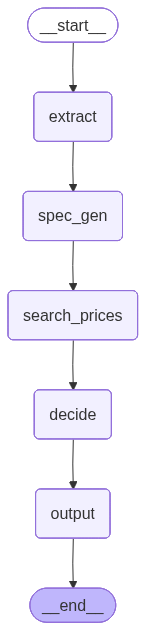

In [81]:
workflow = StateGraph(UserInput, output_schema=GraphOutput)

workflow.add_node("extract", ExtractReqNode)
workflow.add_node("spec_gen", SpecGenNode)
workflow.add_node("search_prices", PriceSearchNode)
workflow.add_node("decide", DecisionNode)
workflow.add_node("output", OutputNode)

workflow.add_edge(START, "extract")
workflow.add_edge("extract", "spec_gen")
workflow.add_edge("spec_gen", "search_prices")
workflow.add_edge("search_prices", "decide")
workflow.add_edge("decide", "output")
workflow.add_edge("output", END)

app = workflow.compile()
display(Image(app.get_graph().draw_mermaid_png()))

In [82]:
text="Нужен ПК для 3D-рендера (Blender) и видеомонтажа. Бюджет примерно 1000-1500 EUR. Важна стабильность и возможность апгрейда."
result = app.invoke(UserInput(text=text))
display(Markdown(result["output"]["content"]))

c:\Users\selik\anaconda3\envs\LLMitmo\Lib\site-packages\pydantic\main.py:464: UserWarning: Pydantic serializer warnings:
  PydanticSerializationUnexpectedValue(Expected `specs_Components` - serialized value may not be as expected [field_name='spec_gen', input_value={'cpu_comp': {'type': 'cp... 70, 'currency': 'EUR'}}, input_type=dict])
  return self.__pydantic_serializer__.to_python(
c:\Users\selik\anaconda3\envs\LLMitmo\Lib\site-packages\pydantic\main.py:464: UserWarning: Pydantic serializer warnings:
  PydanticSerializationUnexpectedValue(Expected `Components` - serialized value may not be as expected [field_name='search_prices', input_value={'cpu_comp': [{'type': 'c...99, 'currency': 'EUR'}]}, input_type=dict])
  return self.__pydantic_serializer__.to_python(
c:\Users\selik\anaconda3\envs\LLMitmo\Lib\site-packages\pydantic\main.py:464: UserWarning: Pydantic serializer warnings:
  PydanticSerializationUnexpectedValue(Expected `SpecProfiles` - serialized value may not be as expected [



### Отчет по подбору ПК для 3D-рендера и видеомонтажа

#### 1. Найденные профили ПК
Был найден один профиль — **basic**, состоящий из следующих компонентов:  
- Процессор: Intel Core i5-6600  
- Видеокарта: Zotac AMP  
- Клавиатура: Cherry G83-6104  

Общая стоимость: **около 1000 EUR** (306.63 + 635.59 + 52.07 EUR).  

#### 2. Сводная таблица по профилю
| Компонент         | Бренд       | Модель       | Цена (EUR) | Примечания                          |
|-------------------|-------------|--------------|------------|-------------------------------------|
| Процессор (CPU)   | Intel       | Core i5-6600 | 306.63     | Устаревший чип (2015 г.), 4 ядра, без гиперпотоков |
| Видеокарта (GPU)  | Zotac       | AMP          | 635.59     | Точная модель не указана. Допустим, это современная карта с CUDA/OpenCL |
| Клавиатура        | Cherry      | G83-6104     | 52.07      | Механическая, но не критична для задач |

#### 3. Анализ компонентов под задачи
**3D-рендер (Blender)**:  
- **Intel Core i5-6600** — устаревший процессор, не оптимизирован для современных нагрузок. Для Blender важны мощные ядра и поддержка многопоточности.  
- **Zotac AMP** — если это современная видеокарта с CUDA/OpenCL, она может помочь с GPU-рендером. Однако без указания модели сложно утверждать её производительность.  

**Видеомонтаж**:  
- Процессор и видеокарта должны поддерживать ускорение через GPU. Intel i5-6600 слаб для многопоточных задач, а видеокарта требует уточнения.  
- Отсутствие оперативной памяти, SSD и блока питания делает конфигурацию неполной.  

**Стабильность и апгрейд**:  
- Устаревший процессор и отсутствие информации о материнской плате/корпусе снижают стабильность.  
- Апгрейд возможен, но требует совместимости компонентов, о чем в профиле не указано.  

#### 4. Итоговая рекомендация
**Профиль "basic" не подходит** для заявленных задач.  
- **Причины**:  
  1. Устаревший процессор (i5-6600) — не обеспечит достаточную производительность для Blender и видеомонтажа.  
  2. Отсутствие ключевых компонентов: оперативной памяти, SSD, блока питания.  
  3. Стоимость профиля (~1000 EUR) позволяет добавить современные компоненты (например, процессор i5-12400F + видеокарту RTX 3060), что даст существенный прирост производительности.  

**Рекомендуемые действия**:  
- Увеличьте бюджет до 1500 EUR и запросите обновлённые конфигурации с:  
  - Процессором 6-8 ядер (например, Intel i5-12400F или AMD Ryzen 5 5600G).  
  - Видеокартой с поддержкой CUDA/OpenCL (RTX 3060 и выше).  
  - SSD (от 500 ГБ) и оперативной памятью 16 ГБ.  
- Уточните возможность апгрейда у продавца (совместимость компонентов).  

**Важно**: Клавиатура не влияет на производительность ПК, её можно приобрести отдельно по мере необходимости.

In [83]:
text="Нужен ПК для работы в браузере и просмотра видео. Бюджет примерно 200-500 EUR. Важна стабильность работы и низкая стоимость."
result2 = app.invoke(UserInput(text=text))
display(Markdown(result2["output"]["content"]))

c:\Users\selik\anaconda3\envs\LLMitmo\Lib\site-packages\pydantic\main.py:464: UserWarning: Pydantic serializer warnings:
  PydanticSerializationUnexpectedValue(Expected `specs_Components` - serialized value may not be as expected [field_name='spec_gen', input_value={'cpu_comp': {'type': 'cp... 25, 'currency': 'EUR'}}, input_type=dict])
  return self.__pydantic_serializer__.to_python(
c:\Users\selik\anaconda3\envs\LLMitmo\Lib\site-packages\pydantic\main.py:464: UserWarning: Pydantic serializer warnings:
  PydanticSerializationUnexpectedValue(Expected `SpecProfiles` - serialized value may not be as expected [field_name='decide', input_value={'profile_name': 'basic',...49, 'currency': 'EUR'}]}, input_type=dict])
  return self.__pydantic_serializer__.to_python(




### Отчет по подбору компьютерной конфигурации

#### Найденные профили ПК
Для запроса пользователя был найден **один подходящий профиль ПК** — **"basic"**. Он полностью соответствует требованиям: бюджет (200–500 EUR), задачи (работа в браузере, просмотр видео) и критерии (стабильность, низкая стоимость). Ниже приведена детальная информация о компонентах и их соответствии запросу.

---

#### Сводная таблица по профилю "basic"
| **Компонент**         | **Бренд**   | **Модель**               | **Стоимость (EUR)** | **Анализ соответствия запросу**                                                                 |
|------------------------|-------------|--------------------------|---------------------|---------------------------------------------------------------------------------------------|
| **Процессор (CPU)**   | AMD         | Sempron 145              | 59.99               | Бюджетный процессор с низким энергопотреблением. Достаточен для базовых задач (браузер, офис, видео). |
| **Видеокарта (GPU)**  | Jaton       | Video-PX658-DLP-EX       | 101.4               | Интегрированная графика, обеспечивающая стабильную работу с HD-видео и базовыми приложениями.     |
| **Клавиатура**        | Kensington  | K64370                   | 16.49               | Надежная и удобная клавиатура для повседневной работы. Устойчива к износу.                       |
| **Итого**             | —           | —                        | **177.88 EUR**      | Общая стоимость значительно ниже бюджета, оставляя возможность на дополнительные компоненты.    |

---

#### Итоговая рекомендация
**Рекомендуемый профиль: "basic"**  
**Причины выбора:**  
1. **Соответствие бюджету:** Общая стоимость (177.88 EUR) находится в нижней части указанного диапазона (200–500 EUR), что позволяет сэкономить или добавить дополнительные компоненты (например, SSD или увеличить объем оперативной памяти).  
2. **Стабильность работы:**  
   - Процессор AMD Sempron 145 и видеокарта Jaton обеспечивают надежную работу для задач, указанных пользователем.  
   - Клавиатура Kensington добавляет удобство и долговечность.  
3. **Минимальные требования:** Все компоненты оптимально подходят для работы в браузере, просмотра видео и других базовых задач.  

**Важно:** Если пользователю потребуется более высокая производительность (например, для работы с несколькими вкладками браузера или редактирования видео), можно рассмотреть добавление 8 ГБ оперативной памяти или SSD-накопителя. Однако в рамках текущих требований профиль "basic" — оптимальный выбор.